### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

#### Prepare kfolds

In [11]:
n_folds = 3
feat_engs = []
df_trains = []
df_vals = []
folds = KFold(n_splits=n_folds, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]

    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    feat_engs.append(feat_eng)
    df_trains.append(df_train)
    df_vals.append(df_val)

#### Bayesian Optimization

In [12]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

In [13]:
int_params = ['num_leaves', 'min_data_in_leaf']  # list of params that needs to be int
def fix_params(params):
    """Fix the params into int"""
    for c in int_params:
        if c in params: 
            params[c] = int(round(params[c]))
    return params

In [14]:
def kfold_cv(**params_update):
    params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    print('params:', params)

    scores = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = cal_score(df_val['total_price'], y_pred_final)
        
        scores.append(score)
    
    tuple_params = tuple(params.items())
    result = [tuple_params, np.mean(scores), scores]
    gsearch_results.append(result)
    return result[1]

In [15]:
gsearch_results = []

In [16]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'learning_rate': (0.01, 0.2),
    'num_leaves': (63, 1023),           # may reduce in dim-reduction exp
    'feature_fraction': (0.1, 1.0),
    'min_data_in_leaf': (5, 100),
    'lambda_l1': (0., 10.),
    'lambda_l2': (0., 10.),
}

optimizer = BayesianOptimization(
    f=kfold_cv,
    pbounds=pbounds,
    random_state=1,
)

In [17]:
%%time
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.47531980423231657, 'lambda_l1': 7.203244934421581, 'lambda_l2': 0.0011437481734488664, 'learning_rate': 0.06744318880004956, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[886]	valid_0's mape: 0.00940239
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[872]	valid_0's mape: 0.00957119
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[810]	valid_0's mape: 0.0095233
|  1        |  4.919e+0 |  0.4753   |  7.203    |  0.001144 |  0.06744  |  18.9

Early stopping, best iteration is:
[667]	valid_0's mape: 0.00965681
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[707]	valid_0's mape: 0.00969475
|  9        |  4.967e+0 |  0.7649   |  1.875    |  8.216    |  0.1809   |  83.44    |  326.1    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.3230354540006949, 'lambda_l1': 1.9060093137406353, 'lambda_l2': 0.7993889159523304, 'learning_rate': 0.03757980889496994, 'min_data_in_leaf': 54, 'num_leaves': 160}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00880735
[4000]	valid_0's mape: 0.00877054
Early stopping, best iteration is:
[3124]	valid_0's mape: 0.00877053
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00894422
[4000]	valid_0's mape: 0.00890169
Early stopping, best iteration is:
[3198]	

In [18]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=20,
)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.2840070247583657, 'lambda_l1': 8.781174363909454, 'lambda_l2': 0.27387593197926163, 'learning_rate': 0.13738882693389642, 'min_data_in_leaf': 45, 'num_leaves': 599}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[640]	valid_0's mape: 0.00993852
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[653]	valid_0's mape: 0.0101186
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[597]	valid_0's mape: 0.0102221
|  13       |  4.637e+0 |  0.284    |  8.781    |  0.2739   |  0.1374   |  44.64   

==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00987212
Early stopping, best iteration is:
[2158]	valid_0's mape: 0.00986971
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00997103
Early stopping, best iteration is:
[2055]	valid_0's mape: 0.00997027
|  21       |  4.781e+0 |  0.1958   |  4.412    |  4.796    |  0.09482  |  60.34    |  822.9    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.6105241549550379, 'lambda_l1': 1.9326879036668465, 'lambda_l2': 8.43246009047967, 'learning_rate': 0.10391393626352807, 'min_data_in_leaf': 84, 'num_leaves': 326}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00913352
Early stopping, best iteration is:
[1165]	valid_0's mape: 0.00913352
==== Fold 2 ====
Training until validation scores don't improve for 1000 rou

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.259447054189499, 'lambda_l1': 8.597047291361243, 'lambda_l2': 9.61052156327296, 'learning_rate': 0.0668320195272593, 'min_data_in_leaf': 87, 'num_leaves': 421}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00953311
Early stopping, best iteration is:
[1981]	valid_0's mape: 0.00953311
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00965587
Early stopping, best iteration is:
[1815]	valid_0's mape: 0.00965587
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00973232
Early stopping, best iteration is:
[1755]	valid_0's mape: 0.00973232
|  30       |  4.826e+0 |  0.2594   |  8.597    |  9.611    |  0.06683  |  86.54    |  420.5    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric'

In [19]:
optimizer.max

{'target': 5359.8593083731475,
 'params': {'feature_fraction': 0.6279298502152968,
  'lambda_l1': 2.0888793018043037,
  'lambda_l2': 3.5719359915369653,
  'learning_rate': 0.017707398403478614,
  'min_data_in_leaf': 32.56320395669039,
  'num_leaves': 340.3869414374069}}

### Round 2

In [20]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'learning_rate': (0.01, 0.02),
    'num_leaves': (63, 1023),           # may reduce in dim-reduction exp
    'feature_fraction': (0.1, 1.0),
    'min_data_in_leaf': (5, 100),
    'lambda_l1': (0., 1.),
    'lambda_l2': (0., 1.),
    ''
}

optimizer = BayesianOptimization(
    f=kfold_cv,
    pbounds=pbounds,
    random_state=1,
)

In [21]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=60,
)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.47531980423231657, 'lambda_l1': 0.7203244934421581, 'lambda_l2': 0.00011437481734488664, 'learning_rate': 0.013023325726318398, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00881108
[4000]	valid_0's mape: 0.0085849
[6000]	valid_0's mape: 0.0085152
[8000]	valid_0's mape: 0.00848541
[10000]	valid_0's mape: 0.00846981
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00846981
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00894014
[4000]	valid_0's mape: 0.00871375
[6000]	valid_0's mape: 0.00864223
[8000]

[8000]	valid_0's mape: 0.00864211
Early stopping, best iteration is:
[8826]	valid_0's mape: 0.0086368
|  6        |  5.48e+03 |  0.4793   |  0.7208   |  0.000988 |  0.01508  |  18.93    |  151.6    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.7925250056687739, 'lambda_l1': 0.591811446257114, 'lambda_l2': 0.056840881436868274, 'learning_rate': 0.01945308318442846, 'min_data_in_leaf': 19, 'num_leaves': 153}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00880152
[4000]	valid_0's mape: 0.00867679
[6000]	valid_0's mape: 0.00864413
Early stopping, best iteration is:
[6966]	valid_0's mape: 0.00863857
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00885197
[4000]	valid_0's mape: 0.00872074
[6000]	valid_0's mape: 0.00868604
[8000]	valid_0's mape: 0.00867743
Early stopping, best iteration is:
[7025]	valid_0's ma

[4000]	valid_0's mape: 0.00882385
[6000]	valid_0's mape: 0.00872949
[8000]	valid_0's mape: 0.0086849
[10000]	valid_0's mape: 0.00866032
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00866032
|  12       |  5.477e+0 |  0.4321   |  0.7832   |  0.02912  |  0.01004  |  19.38    |  152.1    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.7213522338401461, 'lambda_l1': 0.7506388988593415, 'lambda_l2': 0.44229764622103473, 'learning_rate': 0.014585540272052642, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00885447
[4000]	valid_0's mape: 0.00867781
[6000]	valid_0's mape: 0.00862863
[8000]	valid_0's mape: 0.00860728
Early stopping, best iteration is:
[8625]	valid_0's mape: 0.00860385
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00891093
[400

[10000]	valid_0's mape: 0.00934232
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00934232
|  18       |  5.16e+03 |  0.1303   |  0.6868   |  0.3309   |  0.01923  |  18.99    |  151.7    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.7791982201095339, 'lambda_l1': 0.7308283086168874, 'lambda_l2': 0.619582864591375, 'learning_rate': 0.014616131494566122, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00889777
[4000]	valid_0's mape: 0.00872248
[6000]	valid_0's mape: 0.00867486
[8000]	valid_0's mape: 0.00865606
Early stopping, best iteration is:
[8962]	valid_0's mape: 0.00865133
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00893667
[4000]	valid_0's mape: 0.00875868
[6000]	valid_0's mape: 0.00870713
[8000]	valid_0's mape: 0.00868473
Early 

[4000]	valid_0's mape: 0.0088205
[6000]	valid_0's mape: 0.00878334
[8000]	valid_0's mape: 0.00877042
Early stopping, best iteration is:
[8868]	valid_0's mape: 0.00876795
|  24       |  5.446e+0 |  0.8066   |  0.354    |  0.02937  |  0.01904  |  19.68    |  152.0    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.6909375333396892, 'lambda_l1': 0.7681341869504453, 'lambda_l2': 0.2661089392229453, 'learning_rate': 0.011779920366276925, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00892749
[4000]	valid_0's mape: 0.0087063
[6000]	valid_0's mape: 0.00863725
[8000]	valid_0's mape: 0.00860673
[10000]	valid_0's mape: 0.0085906
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0085906
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00897491
[4000]	v

[10000]	valid_0's mape: 0.00874548
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00874548
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00922233
[4000]	valid_0's mape: 0.00897006
[6000]	valid_0's mape: 0.00889093
[8000]	valid_0's mape: 0.00885232
[10000]	valid_0's mape: 0.00883207
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00883207
|  30       |  5.44e+03 |  0.9314   |  0.3716   |  0.6987   |  0.01052  |  19.18    |  152.9    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.8143438290208261, 'lambda_l1': 0.6167546156001364, 'lambda_l2': 0.42911830474756163, 'learning_rate': 0.016156179042252534, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00890297
[4000]	valid_0's mape: 0.0087467
[6000]	valid_0's mape: 

[10000]	valid_0's mape: 0.00868991
Did not meet early stopping. Best iteration is:
[9478]	valid_0's mape: 0.00868988
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0090969
[4000]	valid_0's mape: 0.00889486
[6000]	valid_0's mape: 0.00883338
[8000]	valid_0's mape: 0.00880734
[10000]	valid_0's mape: 0.00879465
Did not meet early stopping. Best iteration is:
[9876]	valid_0's mape: 0.00879464
|  36       |  5.434e+0 |  0.838    |  0.7807   |  0.5709   |  0.01278  |  18.89    |  151.6    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.8614348764159179, 'lambda_l1': 0.3678054236892182, 'lambda_l2': 0.20560071370381838, 'learning_rate': 0.01701803261790301, 'min_data_in_leaf': 20, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00892675
[4000]	valid_0's mape: 0.00877634
[6000]	valid_0's mape: 0.0

[6000]	valid_0's mape: 0.00863724
[8000]	valid_0's mape: 0.00861789
[10000]	valid_0's mape: 0.008611
Did not meet early stopping. Best iteration is:
[9242]	valid_0's mape: 0.008611
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0088873
[4000]	valid_0's mape: 0.00873346
[6000]	valid_0's mape: 0.00868619
[8000]	valid_0's mape: 0.00866632
[10000]	valid_0's mape: 0.00866188
Did not meet early stopping. Best iteration is:
[9029]	valid_0's mape: 0.00866188
|  42       |  5.488e+0 |  0.6516   |  0.5115   |  0.3669   |  0.01635  |  19.58    |  152.6    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.2857253380499387, 'lambda_l1': 0.7417283000966486, 'lambda_l2': 0.31504534667950923, 'learning_rate': 0.014914139020664421, 'min_data_in_leaf': 20, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0089

[8000]	valid_0's mape: 0.00851366
[10000]	valid_0's mape: 0.00849657
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00849655
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00896911
[4000]	valid_0's mape: 0.00871922
[6000]	valid_0's mape: 0.00864204
[8000]	valid_0's mape: 0.00860861
[10000]	valid_0's mape: 0.00859257
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00859257
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0090337
[4000]	valid_0's mape: 0.00877467
[6000]	valid_0's mape: 0.00869886
[8000]	valid_0's mape: 0.00866733
[10000]	valid_0's mape: 0.00865138
Did not meet early stopping. Best iteration is:
[9916]	valid_0's mape: 0.00865136
|  48       |  5.476e+0 |  0.3646   |  0.8678   |  0.02895  |  0.01298  |  19.03    |  152.0    |
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'm

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00913461
[4000]	valid_0's mape: 0.00889856
[6000]	valid_0's mape: 0.0088239
[8000]	valid_0's mape: 0.00879162
[10000]	valid_0's mape: 0.00877383
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00877383
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00910007
[4000]	valid_0's mape: 0.00886429
[6000]	valid_0's mape: 0.00878699
[8000]	valid_0's mape: 0.00875402
[10000]	valid_0's mape: 0.00873719
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00873719
==== Fold 3 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00923447
[4000]	valid_0's mape: 0.00899195
[6000]	valid_0's mape: 0.00891878
[8000]	valid_0's mape: 0.00888421
[10000]	valid_0's mape: 0.00886604
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00886604
|  54       | 

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'feature_fraction': 0.39773627393162614, 'lambda_l1': 0.8605041782201432, 'lambda_l2': 0.25024122532921944, 'learning_rate': 0.01319710911600464, 'min_data_in_leaf': 19, 'num_leaves': 152}
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00885886
[4000]	valid_0's mape: 0.00861301
[6000]	valid_0's mape: 0.00853738
[8000]	valid_0's mape: 0.00850515
[10000]	valid_0's mape: 0.00849049
Did not meet early stopping. Best iteration is:
[9998]	valid_0's mape: 0.00849049
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00897401
[4000]	valid_0's mape: 0.00874015
[6000]	valid_0's mape: 0.00866618
[8000]	valid_0's mape: 0.00863358
[10000]	valid_0's mape: 0.00861796
Did not meet early stopping. Best iteration is:
[9914]	valid_0's mape: 0.00861795
==== Fold 3 ====
Training until validation scores don'

[6000]	valid_0's mape: 0.00875452
[8000]	valid_0's mape: 0.00874234
Early stopping, best iteration is:
[8110]	valid_0's mape: 0.0087421
|  65       |  5.454e+0 |  0.7388   |  0.4332   |  0.8597   |  0.01965  |  19.46    |  151.8    |
CPU times: user 4d 3h 34min 16s, sys: 1h 2min 47s, total: 4d 4h 37min 3s
Wall time: 8h 45min 15s


In [22]:
optimizer.max

{'target': 5514.1957549090375,
 'params': {'feature_fraction': 0.6885218841258391,
  'lambda_l1': 0.24218812218242824,
  'lambda_l2': 0.104811986764205,
  'learning_rate': 0.013518896380851148,
  'min_data_in_leaf': 19.649623579429115,
  'num_leaves': 151.8359352561002}}

In [9]:
%%time
params_gsearch1 = {'num_leaves': [63, 255, 511],           # may reduce in dim-reduction exp
                   'feature_fraction': [0.5, 0.75, 1.0],
                   'min_data_in_leaf': [5, 20, 50]
                   'lambda_l1': [0, 0.01, 0.1],
                   'lambda_l2': [0, 0.01, 0.1],
                  }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    # grid search
    for values in itertools.product(*[params_gsearch1[key] for key in params_gsearch1]):
        params = params_fix.copy()
        params.update( dict(zip(params_gsearch1.keys(), values)) )
        print('params:', params)

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        
        y_pred_final = target_inverse_transform(df_val, y_pred)
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00924973
[4000]	valid_0's mape: 0.00889486
[6000]	valid_0's mape: 0.00873562
[8000]	valid_0's mape: 0.00864773
[10000]	valid_0's mape: 0.00859924
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00859924
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00922818
[4000]	valid_0's mape: 0.00887349
[6000]	valid_0's mape: 0.00872457
[8000]	valid_0's mape: 0.0086457
[10000]	valid_0's mape: 0.00859651
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.

[8000]	valid_0's mape: 0.00882928
[10000]	valid_0's mape: 0.00882544
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00882543
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00898723
[4000]	valid_0's mape: 0.00889822
[6000]	valid_0's mape: 0.008884
Early stopping, best iteration is:
[6852]	valid_0's mape: 0.00888083
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00871849
[4000]	valid_0's mape: 0.00867427
[6000]	valid_0's mape: 0.00866703
[8000]	valid_0's mape: 0.00866505
[10000]	valid_0's mape: 0.00866433
Did not meet early sto

[2000]	valid_0's mape: 0.00947864
[4000]	valid_0's mape: 0.00914916
[6000]	valid_0's mape: 0.00901362
[8000]	valid_0's mape: 0.00894544
[10000]	valid_0's mape: 0.00890538
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00890538
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00949095
[4000]	valid_0's mape: 0.00918489
[6000]	valid_0's mape: 0.00905474
[8000]	valid_0's mape: 0.00899866
[10000]	valid_0's mape: 0.00896628
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00896627
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	

[2000]	valid_0's mape: 0.00898406
[4000]	valid_0's mape: 0.00894599
[6000]	valid_0's mape: 0.00894069
[8000]	valid_0's mape: 0.00893967
[10000]	valid_0's mape: 0.00893939
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00893939
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.0089554
[4000]	valid_0's mape: 0.00892977
[6000]	valid_0's mape: 0.00892525
[8000]	valid_0's mape: 0.00892325
[10000]	valid_0's mape: 0.00892225
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00892225
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 200 rounds.
[2000]

[2000]	valid_0's mape: 0.00882231
[4000]	valid_0's mape: 0.00872889
[6000]	valid_0's mape: 0.00871134
[8000]	valid_0's mape: 0.00870608
[10000]	valid_0's mape: 0.00870444
Did not meet early stopping. Best iteration is:
[9892]	valid_0's mape: 0.00870439
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 200 rounds.
[2000]	valid_0's mape: 0.00905963
[4000]	valid_0's mape: 0.00895269
[6000]	valid_0's mape: 0.00892689
[8000]	valid_0's mape: 0.00891709
[10000]	valid_0's mape: 0.0089136
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.0089136
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 200 rounds.
[2000]	v

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5)),
  5501.863278855861,
  [5527.864888142274, 5498.864225711784, 5478.860722713526]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.75),
   ('min_data_in_leaf', 5)),
  5487.528884854769,
  [5520.8628564734545, 5464.864074281463, 5476.859723809391]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 20)),
  5486.529382166224,
  [5512.864088908585, 5463.864133470911, 5482.859924119177]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learnin

CPU times: user 3d 3h 24min 9s, sys: 45min 31s, total: 3d 4h 9min 40s
Wall time: 6h 36min 46s


In [ ]:
display(gsearch_results1)

### Conclusion

- Round 1 best params (random seed = 123):
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5)),  

Best scores: 5501.863278855861  
[5527.864888142274, 5498.864225711784, 5478.860722713526]

- Round 2 best params (random seed = 123):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0)  
  
Best scores: *5515.529915334645*  
[5532.864763855017, 5514.864357360793, 5498.860624788125]

- Round 2 best params (random seed = 246):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0.1)  
   
Best scores: *5524.863045737181*  
[5528.862755759428, 5530.862894274216, 5514.863487177898]

### Other info

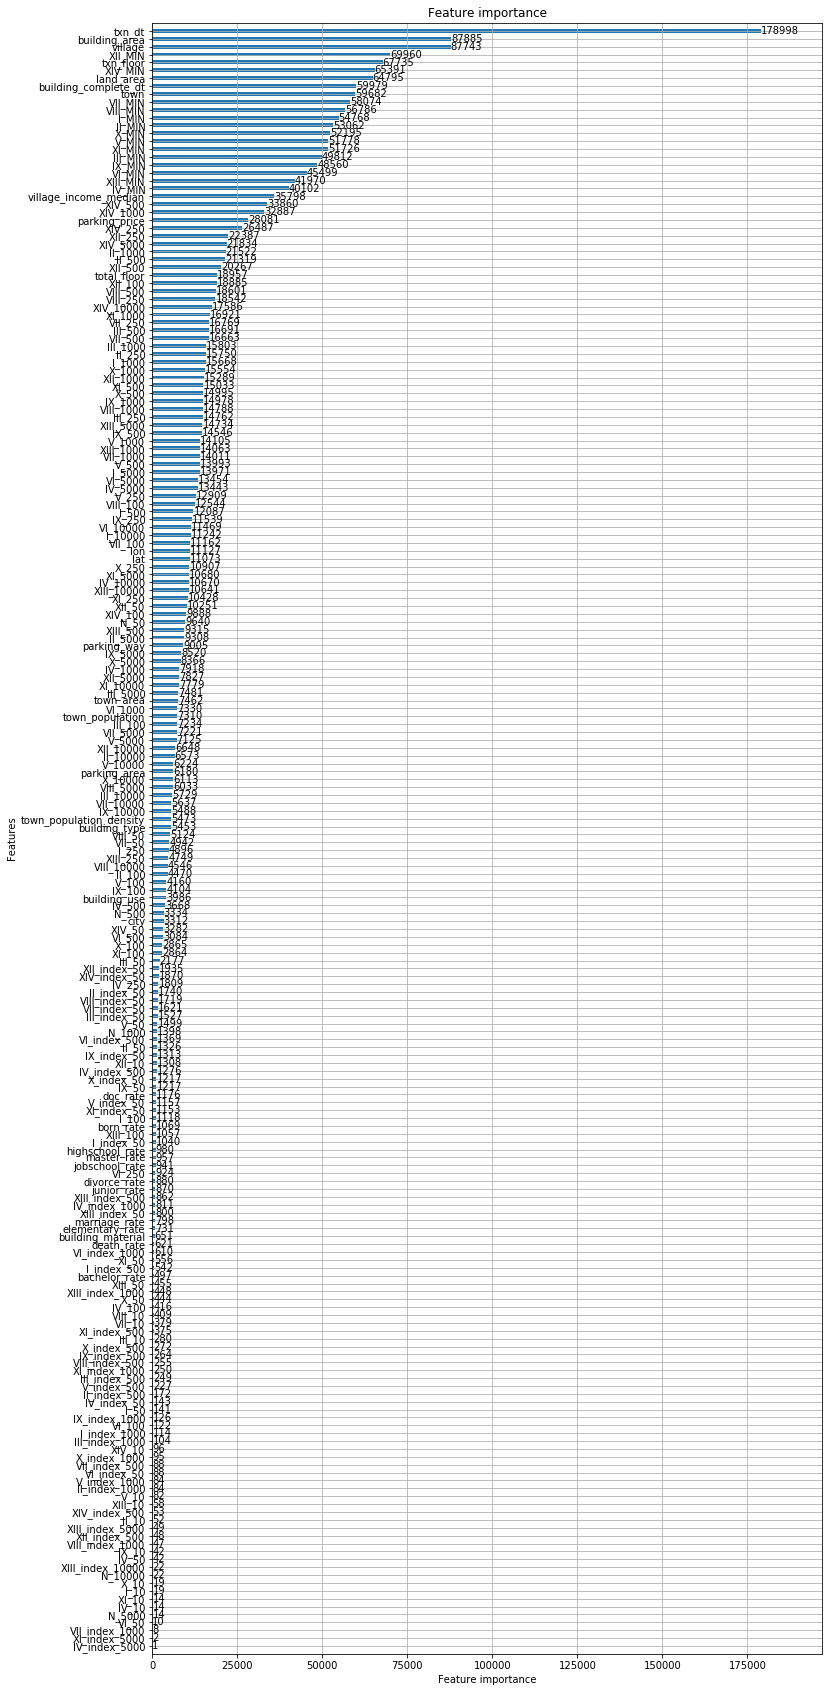

In [16]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

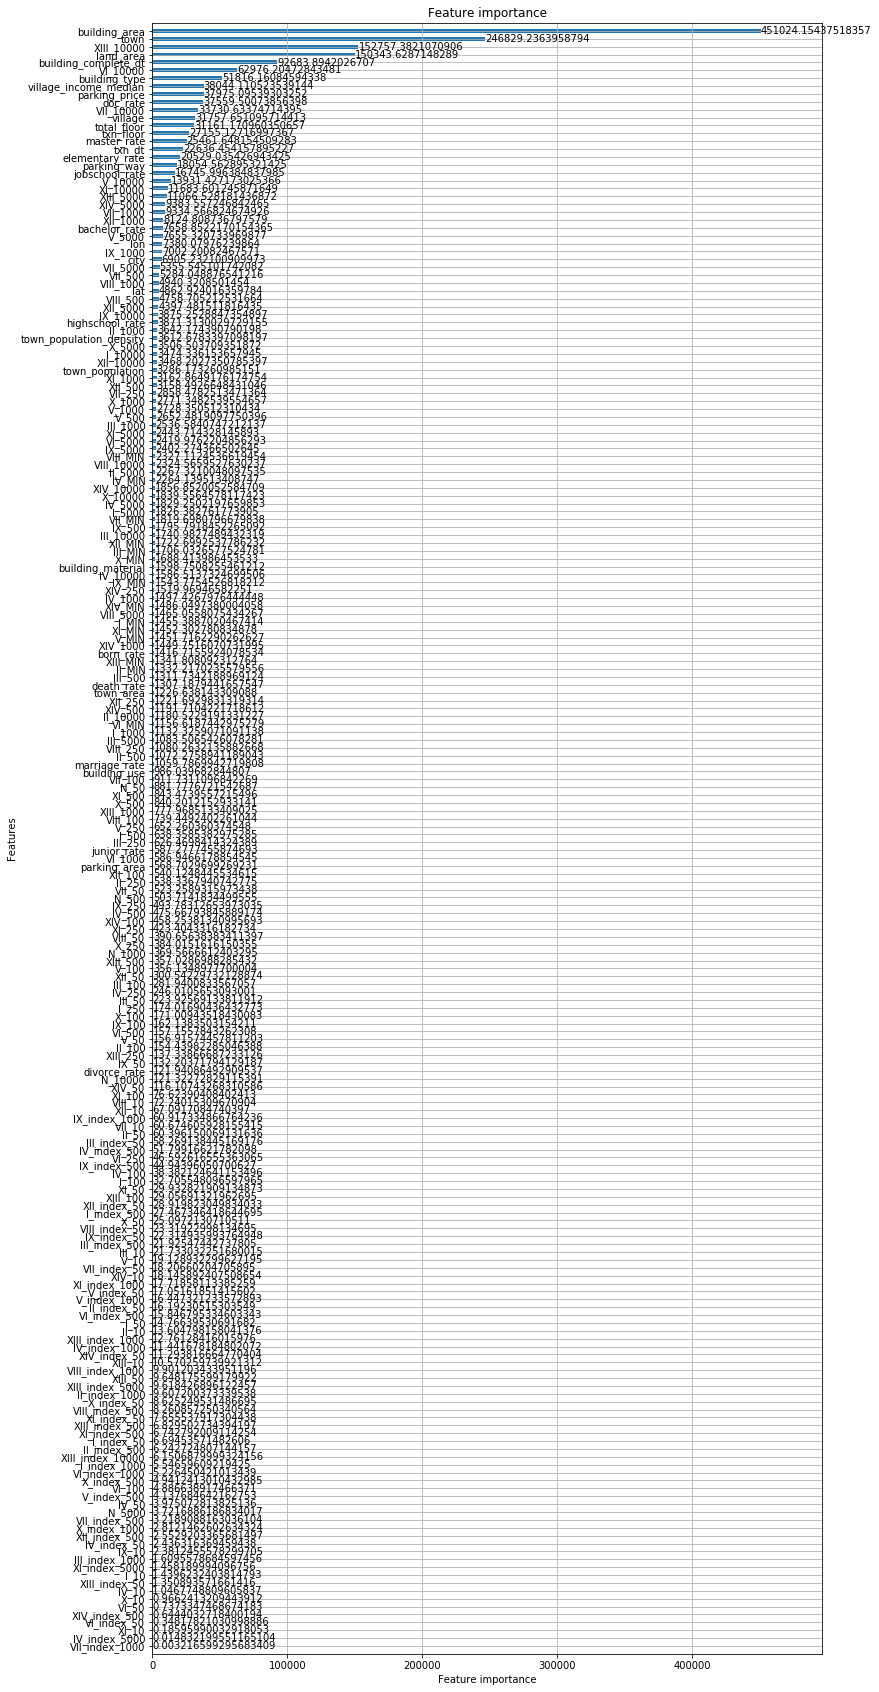

In [17]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()